In [ ]:
import pandas as pd
import sklearn as skl
import numpy as np

from pygam import LogisticGAM, s, l, f, te
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

from pygam import LogisticGAM, s, l, f
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression

import matplotlib.ticker as mtick



In [ ]:
# plotting functions 

def get_y(df,death_type):
  return df[death_type].to_frame()

def filter_feature(df,ft):
  return df.loc[df[ft] == 1]

plt.rcParams['font.size'] = '12'
# i_term refers to the ith term in XX. 
# e.g. the 0th term is "median_temp", the 1st term is "temp_gap"
i_term = 0
def plot_minimum(X_grid, gam):
  i = np.argmin(gam.partial_dependence(term=i_term, X=X_grid))
  x_min = X_grid[:, i_term][i]
  y_min = gam.partial_dependence(term=i_term, X=X_grid)[i]
  plt.plot(x_min, y_min, marker='o')
  plt.annotate(round(x_min, 1), # this is the text
                 (x_min,y_min), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
  return(round(x_min,1))

def plot_graph(g, title):
  f = plt.figure(figsize = (8, 5))
  XX = g.generate_X_grid(term=i_term)
  x_min = plot_minimum(XX, g)
  plt.plot(XX[:, i_term], g.partial_dependence(term=i_term, X=XX), c='b')
  plt.plot(XX[:, i_term], g.partial_dependence(term=i_term, X=XX, width=.95)[1], c='r', ls='--')
  
  plt.title(title, fontsize = 14)
  plt.xlabel('Temperature', fontsize=12)
  plt.show()
  return(x_min)



In [ ]:
# GAM functions

def get_splines_best_accuracy(df,subgroups, n_splines_min, n_splines_max,death_outcome):
  splines = {}
  accuracies={}
  for index, i in enumerate(subgroups):
    df_subgroup = filter_feature(df,i)
    y = get_y(df_subgroup,death_outcome)
    X = df_subgroup[["median_temp", "age","gender","apsiii", "dialysis", "vasopressor", "steroids", "ventilation","sofa","charlson"]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
    max_accuracy = 0
    n_splines = 0
    for j in range(n_splines_min, n_splines_max):
      gam = LogisticGAM(terms=(s(0, n_splines = j) + l(1) + f(2) + l(3) + f(4) + f(5) + f(6) + f(7) +l(8) +l(9))).fit(X_train, y_train)
      predictions = gam.predict(X_test)
      accuracy = accuracy_score(y_test, predictions)
      if (accuracy > max_accuracy):
        n_splines = j
        max_accuracy = accuracy
    splines[i] = n_splines
    accuracies[i] = round(max_accuracy,2)
  #print(splines)
  return splines, accuracies

def get_splines_best_auc(df,subgroups, n_splines_min, n_splines_max,death_outcome):
  splines = {}
  aucs = {}
  for index, i in enumerate(subgroups):
    df_subgroup = filter_feature(df,i)
    y = get_y(df_subgroup,death_outcome)
    X = df_subgroup[["median_temp", "age","gender","apsiii", "dialysis", "vasopressor", "steroids", "ventilation","sofa","charlson"]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
    max_auc = 0
    n_splines = 0
    for j in range(n_splines_min, n_splines_max):
      gam = LogisticGAM(terms=(s(0, n_splines = j) + l(1) + f(2) + l(3) + f(4) + f(5) + f(6) + f(7) +l(8)+l(9))).fit(X_train, y_train)
      predictions = gam.predict_proba(X_test)
      auc = roc_auc_score(y_test, predictions)
      if (auc > max_auc):
        n_splines = j
        max_auc = auc
    splines[i] = n_splines
    aucs[i] = round(max_auc,2)
  #print(splines)
  return splines, aucs

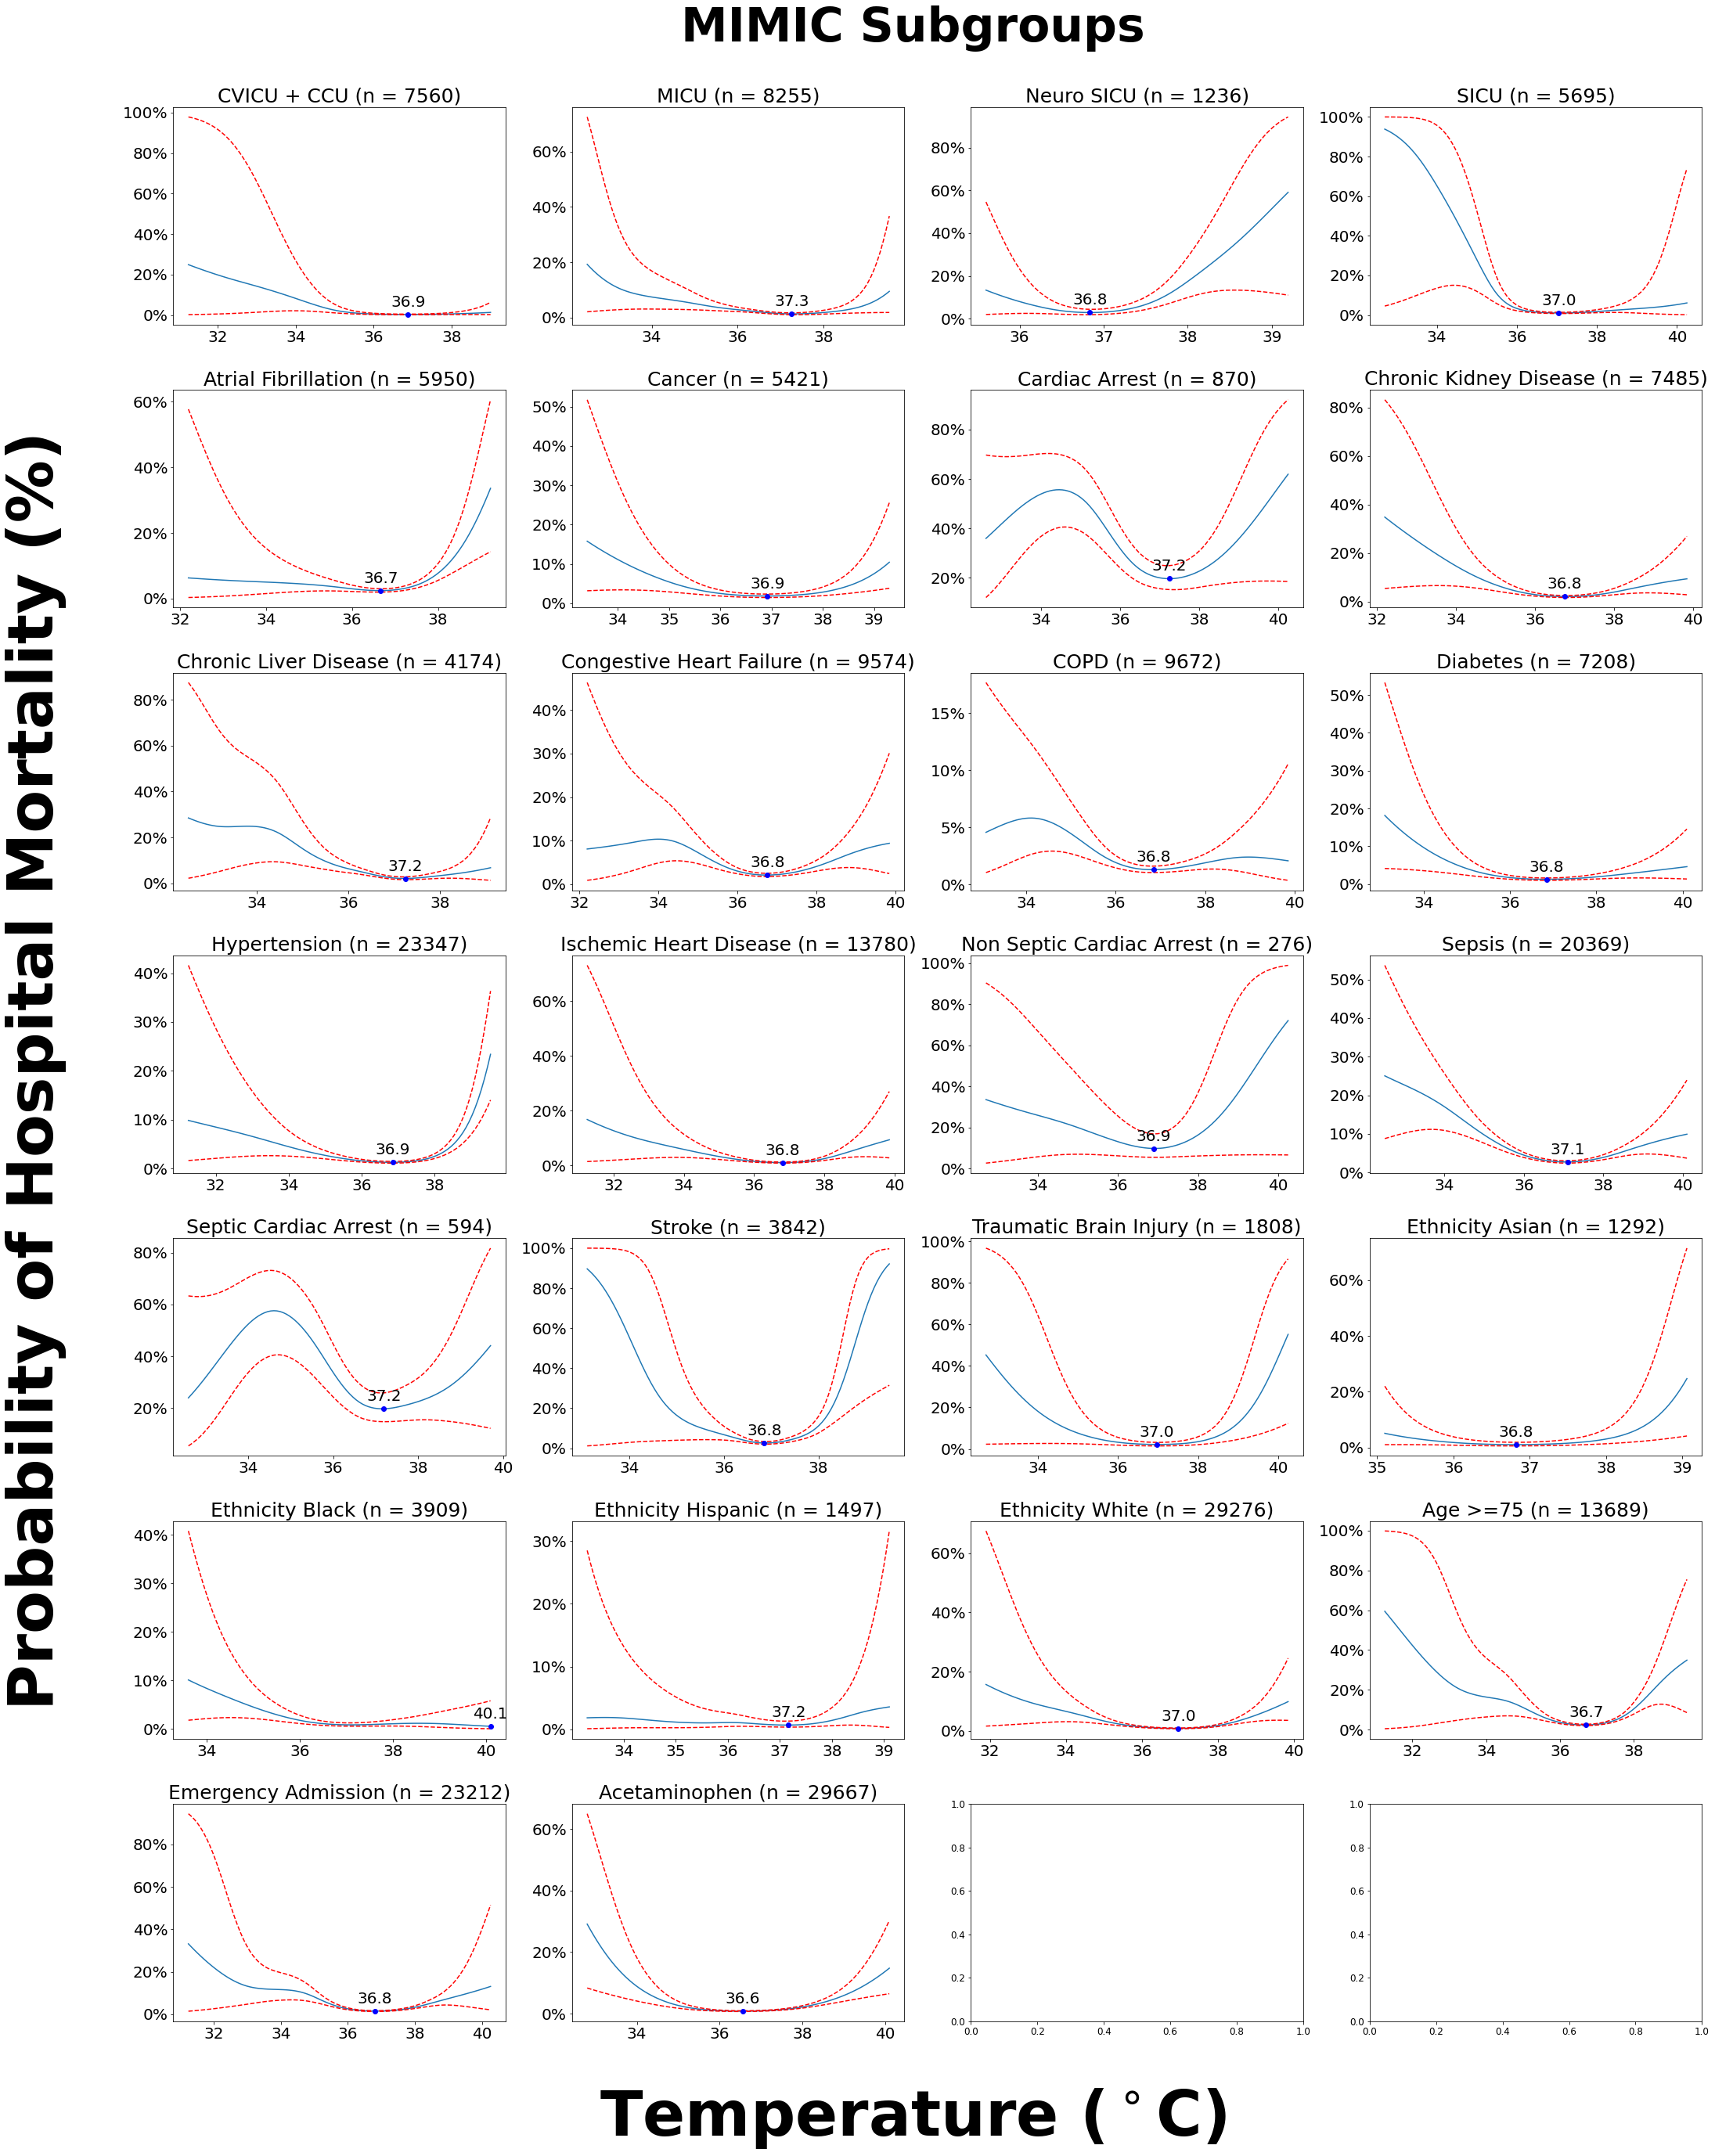

In [ ]:
#2023

merged_path = "mimic_static.csv"
df_merged_mimic = pd.read_csv(merged_path)

# mimic png
subgroups = ["cvicu_ccu","micu", "neuro_sicu", "sicu", "atrial_fibrillation","cancer","cardiac_arrest","ckd","cld","chf","copd",
             "diabetes","hypertension","ihd","non_septic_cardiac_arrest","sepsis_primary","septic_cardiac_arrest","stroke_primary","tbi_primary","is_asian",
             "is_black","is_hispanic","is_white","older_75","emer_admission","acetaminophen"]

titles = [ "CVICU + CCU", "MICU", "Neuro SICU", "SICU", "Atrial Fibrillation", "Cancer", "Cardiac Arrest", "Chronic Kidney Disease","Chronic Liver Disease",
          "Congestive Heart Failure", "COPD","Diabetes","Hypertension","Ischemic Heart Disease", "Non Septic Cardiac Arrest",
          "Sepsis","Septic Cardiac Arrest","Stroke","Traumatic Brain Injury","Ethnicity Asian","Ethnicity Black","Ethnicity Hispanic","Ethnicity White",
          "Age >=75","Emergency Admission","Acetaminophen"]


actual_splines = {'all_patients': 9, 'micu': 12, 'neuro_sicu': 9, 'sicu': 15, 'cvicu_ccu': 10, 'stroke_primary': 15, 'sepsis_primary': 8, 'cardiac_arrest': 9,
                  'non_septic_cardiac_arrest': 10,'septic_cardiac_arrest':10, 'older_75': 15, 'chf': 10, 'copd': 9, 'cld': 13,
                  'atrial_fibrillation': 9, 'emer_admission': 13, 'cancer': 7, 'ihd': 9, 'hypertension': 7, 'is_black': 9,
                  'is_white': 9, 'is_asian': 8, 'is_hispanic': 13,'ckd': 8, 'diabetes': 7, 'acetaminophen': 7, "tbi_primary": 9}
## plotting
rows = 7
cols = 4
fig, axs = plt.subplots(rows,cols,figsize=(40,10));
fig.subplots_adjust(hspace=.3,wspace=.2)
#fig.tight_layout()
fig.set_figheight(45)
fig.set_figwidth(35)
i_term = 0
mimic_temp_mins = {}
mimic_subgroup_sizes={}


for i in range(len(subgroups)):
    df_subgroup = filter_feature(df_merged_mimic,subgroups[i])
    y = get_y(df_subgroup,"icu_death")
    X = df_subgroup[["median_temp", "age","gender","apsiii", "dialysis", "vasopressor", "steroids", "ventilation", "sofa","charlson"]]
    size = X.shape[0]

    median_age = np.median(X.age)
    median_apsiii = np.median(X.apsiii)
    median_gender = np.median(X.gender)
    median_dialysis = np.median(X.dialysis)
    median_vasopressor = np.median(X.vasopressor)
    median_steroids = np.median(X.steroids)
    median_ventilation = np.median(X.ventilation)
    median_sofa = np.median(X.sofa)
    median_charlson = np.median(X.charlson)

    age_vec = [median_age] * 100
    apsiii_vec = [median_apsiii] * 100
    gender_vec = [median_gender] * 100
    dialysis_vec = [median_dialysis] * 100
    vasopressor_vec = [median_vasopressor] * 100
    steroids_vec = [median_steroids] * 100
    ventilation_vec = [median_ventilation] * 100
    sofa_vec = [median_sofa] * 100
    charlson_vec = [median_charlson] * 100
    prop_vec = np.arange(0,100)

    median_temp_x_axis = np.linspace(min(X.median_temp),max(X.median_temp),100)
    test = pd.DataFrame({'median_temp':median_temp_x_axis,'age':age_vec, 'gender':gender_vec, 'apsiii':apsiii_vec, 'dialysis':dialysis_vec, 'vasopressor':vasopressor_vec,'steroids':steroids_vec,
                     'ventilation': ventilation_vec, 'sofa':sofa_vec, 'charlson':charlson_vec})

    gam = LogisticGAM(terms=(s(0, n_splines = actual_splines[subgroups[i]])  + l(1) + f(2) + l(3) + f(4) + f(5) + f(6) + f(7) + l(8) + l(9))).fit(X, y)
    
    gam_predictions = gam.predict_mu(test) * 100
    gam_ci = gam.confidence_intervals(test) *100

    XX = gam.generate_X_grid(term=i_term)
    #i_term = 9 
    ix = np.argmin(gam_predictions)
    x_min = median_temp_x_axis[ix]
    mimic_temp_mins[titles[i]] = round(x_min,1)
    mimic_subgroup_sizes[titles[i]] = size

    #y_min = gam.partial_dependence(term=i_term, X=XX)[ix]
    axs = axs.flatten()
    #axs[i].plot(x_min, y_min, 'bo')

    y_logits = gam.partial_dependence(term=i_term, X=XX)
    y_probability = (np.exp(y_logits)/(1+np.exp(y_logits)) ) *100

    y_ci_logits = gam.partial_dependence(term=i_term, X=XX, width=.95)[1]
    y_ci_probability = (np.exp(y_ci_logits)/(1+np.exp(y_ci_logits)) ) *100
    
    axs[i].plot(XX[:, i_term], gam_predictions)
    axs[i].plot(XX[:, i_term], gam_ci, c='r', ls='--')
    
    axs[i].tick_params(axis="x", labelsize=20)
    axs[i].tick_params(axis="y", labelsize=20)

    y_min = gam_predictions[ix]
    axs[i].plot(x_min, y_min, 'bo')

    axs[i].annotate(round(x_min, 1), # this is the text
            (x_min,y_min), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center',size=20)


    #axs[i].plot(XX[:, i_term], gam.partial_dependence(term=i_term, X=XX))
    #axs[i].plot(XX[:, i_term], gam.partial_dependence(term=i_term, X=XX, width=.95)[1], c='r', ls='--')
    axs[i].set_title(titles[i] + " (n = " + str(size) + ")", size = 25);
    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

fig.suptitle("MIMIC Subgroups",fontsize=60,y=0.92,fontweight="bold")
fig.text(0.5, 0.08, 'Temperature ($^\circ$C)', ha='center',fontsize=80, fontweight="bold")
fig.text(0.04, 0.5, 'Probability of Hospital Mortality (%)', va='center', rotation='vertical',fontsize=80, fontweight="bold")

fig.savefig('mimic_subgroups.png')

#EICU

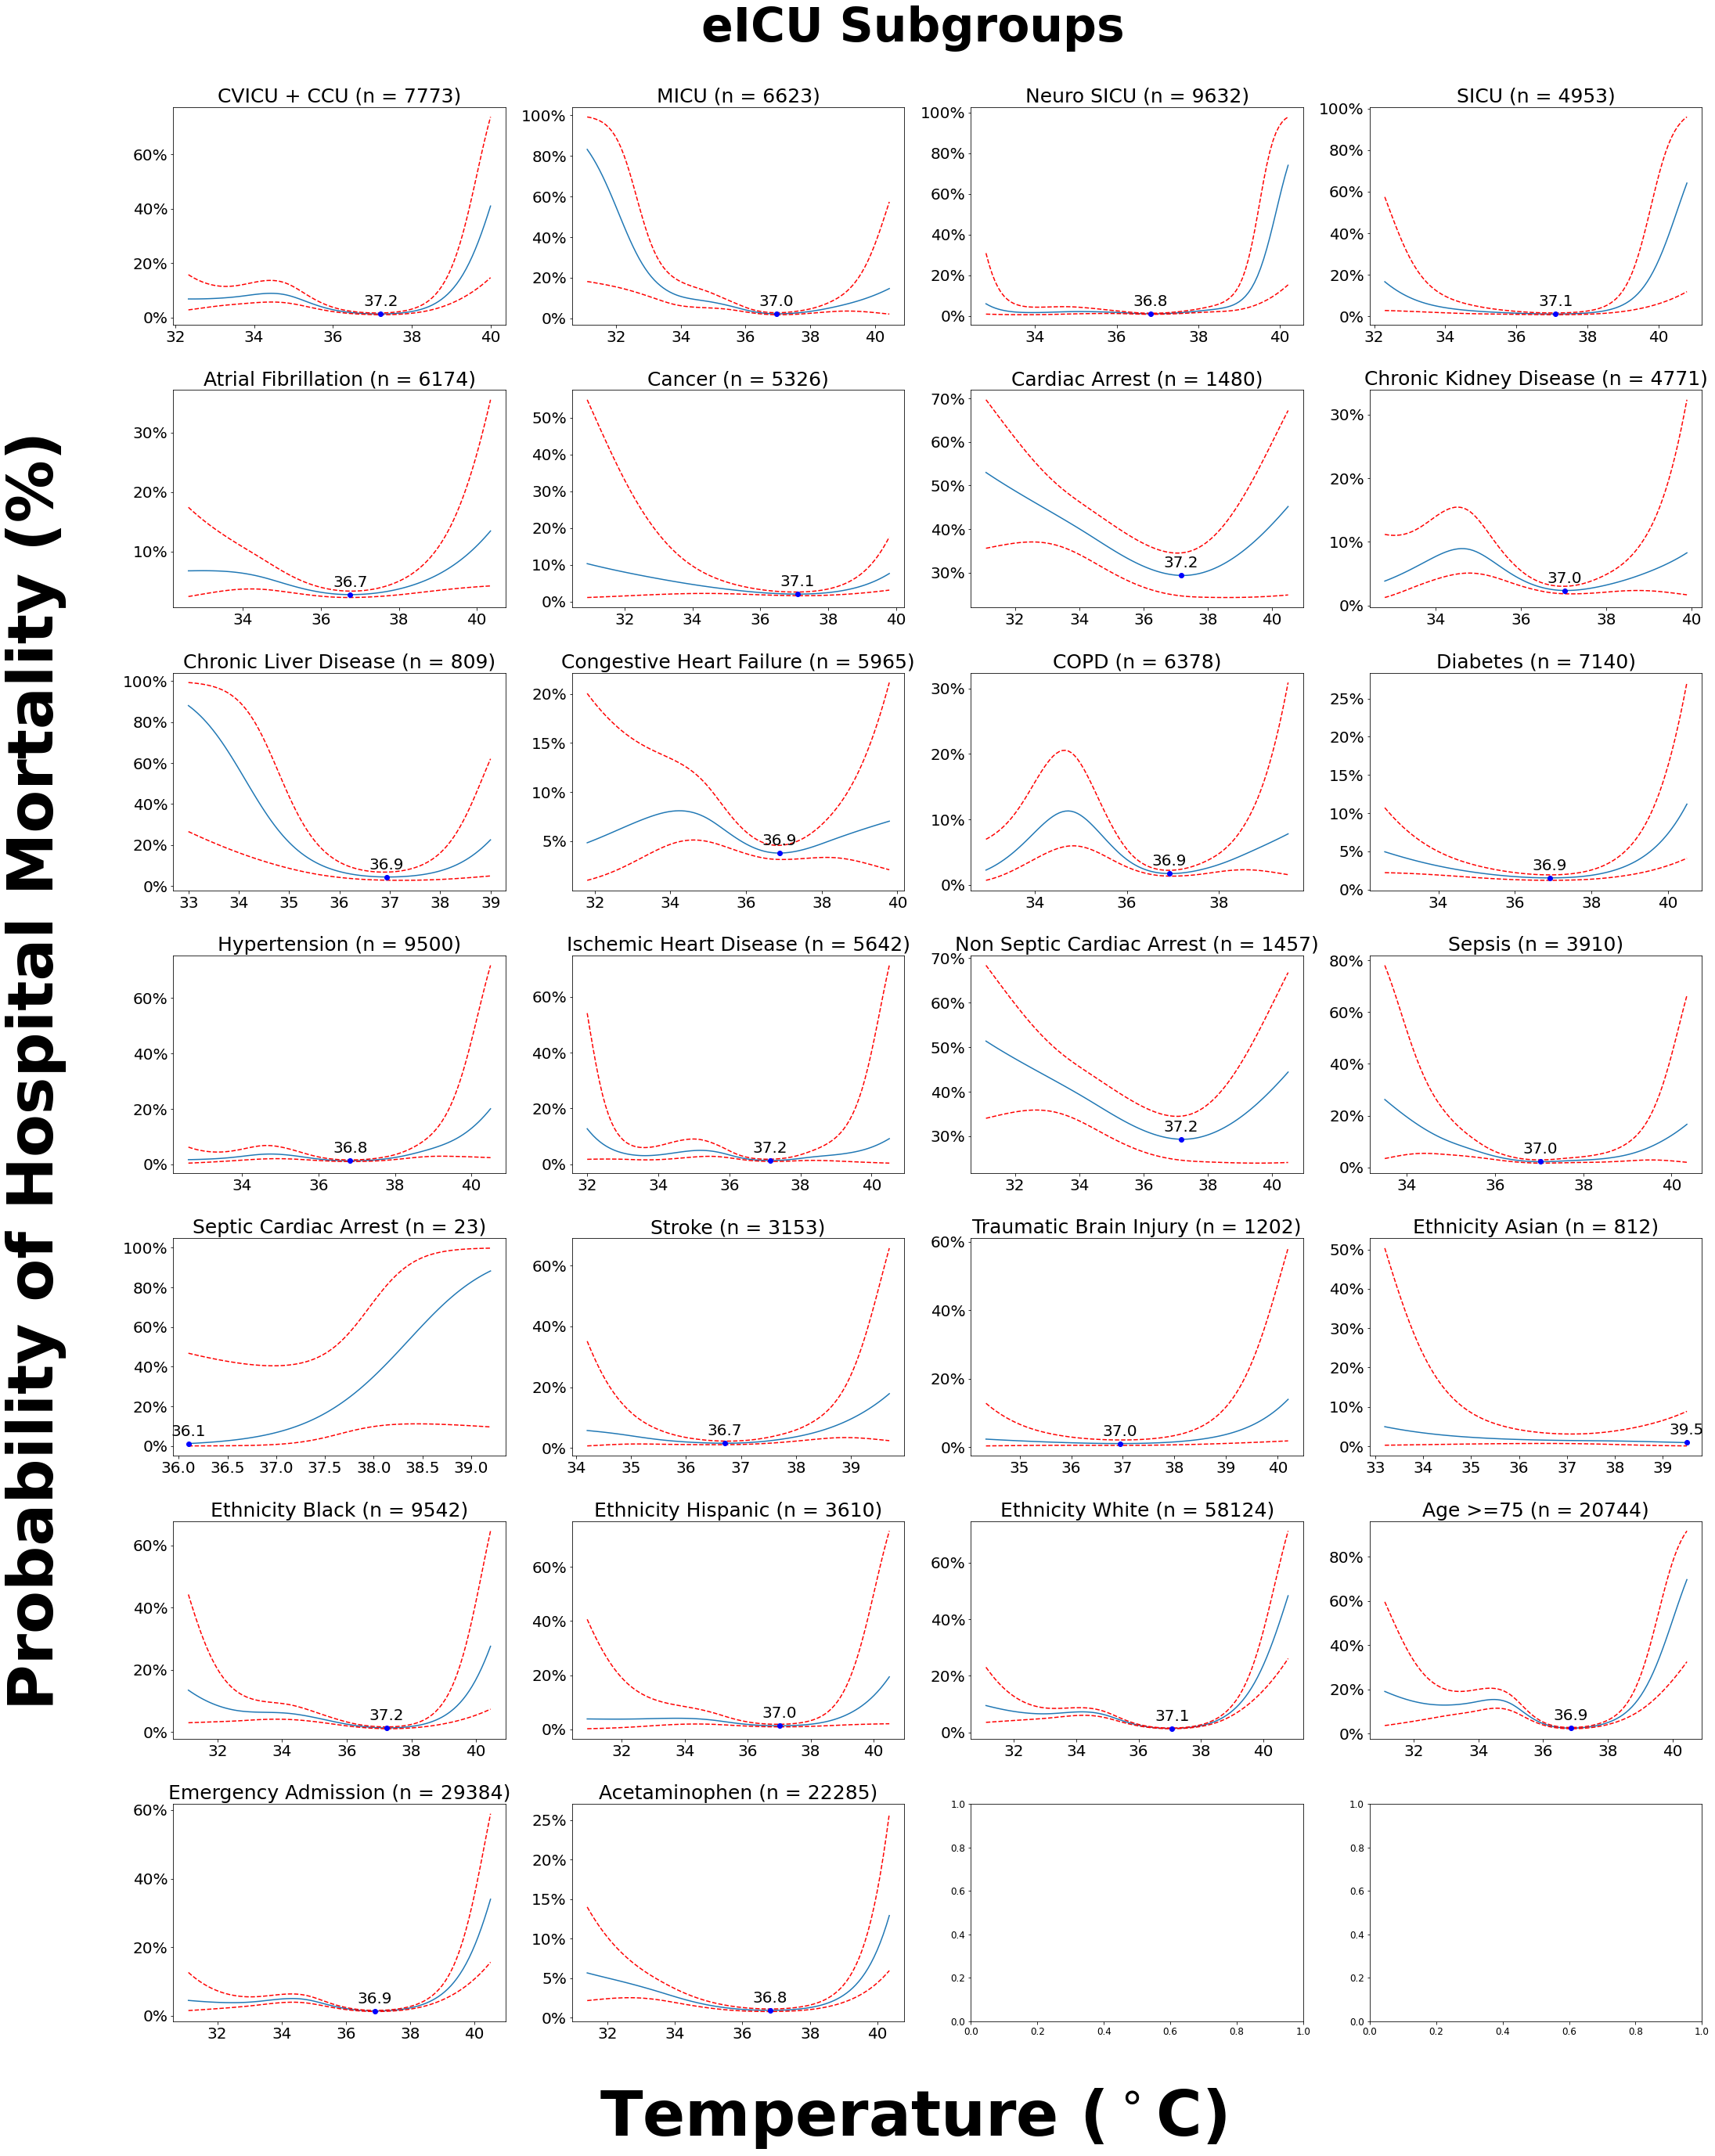

In [ ]:
#2023
merged_path = "eicu_static.csv"
df_merged_eicu = pd.read_csv(merged_path)

# eicu png
subgroups = ["cvicu_ccu","micu", "neuro_sicu", "sicu", "atrial_fibrillation","cancer","cardiac_arrest","ckd","cld","chf","copd",
             "diabetes","hypertension","ihd","non_septic_cardiac_arrest","sepsis_primary","septic_cardiac_arrest","stroke_primary","tbi_primary","is_asian",
             "is_black","is_hispanic","is_white","older_75","emer_admission","acetaminophen"]

titles = [ "CVICU + CCU", "MICU", "Neuro SICU", "SICU", "Atrial Fibrillation", "Cancer", "Cardiac Arrest", "Chronic Kidney Disease","Chronic Liver Disease",
          "Congestive Heart Failure", "COPD","Diabetes","Hypertension","Ischemic Heart Disease", "Non Septic Cardiac Arrest",
          "Sepsis","Septic Cardiac Arrest","Stroke","Traumatic Brain Injury","Ethnicity Asian","Ethnicity Black","Ethnicity Hispanic","Ethnicity White",
          "Age >=75","Emergency Admission","Acetaminophen"]

actual_splines = {'all_patients': 15, 'micu': 13, 'neuro_sicu': 14, 'sicu': 10, 'cvicu_ccu': 9, 'stroke_primary': 11, 'sepsis_primary': 13, "cardiac_arrest": 6,
        'non_septic_cardiac_arrest': 6, 'septic_cardiac_arrest': 7, 'older_75': 10, 'chf': 8, 'copd': 10, 'cld': 8, 'atrial_fibrillation': 7,
        'emer_admission': 8, 'cancer': 7, 'ihd': 14, 'hypertension': 11, 'is_black': 9, 'is_white': 8, 'is_asian': 8, 'is_hispanic': 10,
        'ckd': 10, 'diabetes': 6, 'acetaminophen': 7, 'ischemic_stroke_primary': 6, 'hemorrhagic_stroke_primary': 5, 'tbi_primary' : 7}
## plotting
rows = 7
cols = 4
fig, axs = plt.subplots(rows,cols,figsize=(40,10));
fig.subplots_adjust(hspace=.3,wspace=.2)
#fig.tight_layout()
fig.set_figheight(45)
fig.set_figwidth(35)
i_term = 0
eicu_temp_mins = {}
eicu_subgroup_sizes={}

for i in range(len(subgroups)):
    df_subgroup = filter_feature(df_merged_eicu_new,subgroups[i])
    y = get_y(df_subgroup,"icu_death")
    X = df_subgroup[["median_temp", "age","gender","apsiii", "dialysis", "vasopressor", "steroids", "ventilation", "sofa","charlson"]]
    size = X.shape[0]

    median_age = np.median(X.age)
    median_apsiii = np.median(X.apsiii)
    median_gender = np.median(X.gender)
    median_dialysis = np.median(X.dialysis)
    median_vasopressor = np.median(X.vasopressor)
    median_steroids = np.median(X.steroids)
    median_ventilation = np.median(X.ventilation)
    median_sofa = np.median(X.sofa)
    median_charlson = np.median(X.charlson)

    age_vec = [median_age] * 100
    apsiii_vec = [median_apsiii] * 100
    gender_vec = [median_gender] * 100
    dialysis_vec = [median_dialysis] * 100
    vasopressor_vec = [median_vasopressor] * 100
    steroids_vec = [median_steroids] * 100
    ventilation_vec = [median_ventilation] * 100
    sofa_vec = [median_sofa] * 100
    charlson_vec = [median_charlson] * 100
    prop_vec = np.arange(0,100)

    median_temp_x_axis = np.linspace(min(X.median_temp),max(X.median_temp),100)
    test = pd.DataFrame({'median_temp':median_temp_x_axis,'age':age_vec, 'gender':gender_vec, 'apsiii':apsiii_vec, 'dialysis':dialysis_vec, 'vasopressor':vasopressor_vec,'steroids':steroids_vec,
                     'ventilation': ventilation_vec, 'sofa':sofa_vec, 'charlson':charlson_vec})

    gam = LogisticGAM(terms=(s(0, n_splines = actual_splines[subgroups[i]])  + l(1) + f(2) + l(3) + f(4) + f(5) + f(6) + f(7) + l(8) + l(9))).fit(X, y)
    
    gam_predictions = gam.predict_mu(test) * 100
    gam_ci = gam.confidence_intervals(test) *100

    XX = gam.generate_X_grid(term=i_term)
    ix = np.argmin(gam_predictions)
    x_min = median_temp_x_axis[ix]
    eicu_temp_mins[titles[i]] = round(x_min,1)
    eicu_subgroup_sizes[titles[i]] = size

    axs = axs.flatten()

    y_logits = gam.partial_dependence(term=i_term, X=XX)
    y_probability = (np.exp(y_logits)/(1+np.exp(y_logits)) ) *100

    y_ci_logits = gam.partial_dependence(term=i_term, X=XX, width=.95)[1]
    y_ci_probability = (np.exp(y_ci_logits)/(1+np.exp(y_ci_logits)) ) *100
    
    axs[i].plot(XX[:, i_term], gam_predictions)
    axs[i].plot(XX[:, i_term], gam_ci, c='r', ls='--')
    
    axs[i].tick_params(axis="x", labelsize=20)
    axs[i].tick_params(axis="y", labelsize=20)

    y_min = gam_predictions[ix]
    axs[i].plot(x_min, y_min, 'bo')

    axs[i].annotate(round(x_min, 1), # this is the text
            (x_min,y_min), # these are the coordinates to position the label
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center', size = 20)

    axs[i].set_title(titles[i] + " (n = " + str(size) + ")",size=25);
    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

fig.suptitle("eICU Subgroups",fontsize=60,y=0.92, fontweight="bold")
fig.text(0.5, 0.08, 'Temperature ($^\circ$C)', ha='center',fontsize=80, fontweight="bold")
fig.text(0.04, 0.5, 'Probability of Hospital Mortality (%)', va='center', rotation='vertical',fontsize=80, fontweight="bold")

fig.savefig('eicu_subgroups.png')